### Package Installation and Environment Setup
* Install required packages
* Check PyTorch installation and CUDA availability

In [175]:
!pip install numpy torch torchvision pillow matplotlib tqdm gdown opencv-python
import torch
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")

PyTorch version: 2.6.0+cu126
CUDA available: True
CUDA device: NVIDIA GeForce RTX 3060 Ti



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


### Download and Extract CAPTCHA Images from Google Drive

In [176]:
import os
import gdown
from pathlib import Path
import zipfile
import shutil

# Create directories
os.makedirs('data', exist_ok=True)
os.makedirs('data/images', exist_ok=True)

file_id = '1Qy4geTaJqoRPuaut8V-VFQYpnQS4gTds'
output = 'data/captcha_images.zip'
CAPTCHA_DIR = 'data/images'

# Check if the directory already exists
if os.path.exists(CAPTCHA_DIR) and os.listdir(CAPTCHA_DIR):
    print(f"Directory '{CAPTCHA_DIR}' already exists and is not empty.")

else:
    print(f"Directory '{CAPTCHA_DIR}' does not exist or is empty. Proceeding with download.")
    print("Downloading CAPTCHA images from Google Drive...")
    try:
        url = f'https://drive.google.com/uc?id={file_id}'
        gdown.download(url, output, quiet=False)
        print("Download complete!")
        print("Extracting ZIP file...")
        try:
            with zipfile.ZipFile(output, 'r') as zip_ref:
                zip_ref.extractall('data')
            print("Extraction complete!")

            # Check where the PNG files actually went and move them if needed
            data_dir_files = [f for f in os.listdir('data') if f.lower().endswith('.png')]

            if data_dir_files:
                print(f"Found {len(data_dir_files)} PNG files in 'data' directory")
                print("Moving files to 'data/images'...")

                # Move all PNG files from 'data' to 'data/images'
                for file in data_dir_files:
                    src_path = os.path.join('data', file)
                    dst_path = os.path.join('data/images', file)
                    shutil.move(src_path, dst_path)

                print(f"Successfully moved {len(data_dir_files)} PNG files to 'data/images'")
            else:
                # Check if images might be in a subdirectory
                png_files = []
                for root, dirs, files in os.walk("data"):
                    for file in files:
                        if file.lower().endswith('.png'):
                            full_path = os.path.join(root, file)
                            png_files.append(full_path)

                if png_files:
                    print(f"Found {len(png_files)} PNG files in subdirectories")
                    print("First few files:")
                    for file in png_files[:5]:
                        print(f"  - {file}")

                    # Extract the directory where most images are
                    dir_counts = {}
                    for file in png_files:
                        parent_dir = os.path.dirname(file)
                        dir_counts[parent_dir] = dir_counts.get(parent_dir, 0) + 1

                    # Find directory with most images
                    most_common_dir = max(dir_counts.items(), key=lambda x: x[1])[0]
                    print(f"Most images found in: {most_common_dir}")

                    # Update CAPTCHA_DIR to this location
                    CAPTCHA_DIR = most_common_dir
                else:
                    print("No PNG files found after extraction")
                    CAPTCHA_DIR = 'data/images'  # Default location

        except zipfile.BadZipFile:
            print("Error: The downloaded file is not a valid ZIP file.")
            print("Please upload a valid ZIP file containing CAPTCHA images")
    except Exception as e:
        print(f"Error downloading or extracting the file: {str(e)}")
        print("Please upload the CAPTCHA images manually")

Directory 'data/images' already exists and is not empty.


### CAPTCHA Recognition Challenge

In this notebook, we'll build a baseline model for recognizing text in CAPTCHA images.
CAPTCHAs (Completely Automated Public Turing test to tell Computers and Humans Apart)
are distorted text images designed to be difficult for computers to read.

Your task is to improve this baseline model in one of the following ways:
1. Add data augmentation for better robustness
2. Modify the architecture to reduce inference time
3. Improve preprocessing to handle noise

The baseline model achieves approximately 40-60% accuracy with high variance.
Your goal is to demonstrate measurable improvement over this baseline.

In [177]:
import os
from pathlib import Path
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image, ImageFilter, ImageEnhance
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import random

# Constant for CTC blank token
BLANK_TOKEN = 0

### Configuration

This Config class contains all the parameters for our model and training process.
You might want to experiment with these values as you improve the model.

In [178]:
class Config:
    # Model parameters
    IMG_WIDTH = 65
    IMG_HEIGHT = 25
    DROPOUT_RATE = 0.3

    # Training parameters
    BATCH_SIZE = 64
    LEARNING_RATE = 0.01
    NUM_EPOCHS = 60

    # Dataset parameters
    TARGET_FOLDER = CAPTCHA_DIR
    MAX_SAMPLES = 4000            # Maximum number of samples to use
    TRAIN_RATIO = 0.9             # Ratio of training to validation data

    # Misc
    RANDOM_SEED = 69
    MODEL_SAVE_PATH = 'captcha_model.pth'

CONFIG = Config()

### Dataset Class
The CaptchaDataset class handles loading and preprocessing CAPTCHA images.
It converts the images to tensors and prepares the labels for training.

In [179]:
class CaptchaDataset(Dataset):
    def __init__(self, image_paths, labels, char_to_idx, max_length, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.char_to_idx = char_to_idx
        self.max_length = max_length
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        try:
            img_path = self.image_paths[idx]
            image = Image.open(img_path).convert('L')  # Convert to grayscale

            if self.transform:
                image = self.transform(image)

            label = self.labels[idx]
            label_indices = [self.char_to_idx[c] for c in label]
            label_length = len(label)

            # Pad label to max_length
            label_indices = label_indices + [BLANK_TOKEN] * (self.max_length - label_length)

            return {
                'image': image,
                'label': torch.tensor(label_indices, dtype=torch.long),
                'label_length': torch.tensor(label_length, dtype=torch.long)
            }
        except Exception as e:
            print(f"Error loading image {self.image_paths[idx]}: {e}")
            return {
                'image': torch.zeros((1, CONFIG.IMG_HEIGHT, CONFIG.IMG_WIDTH)),
                'label': torch.tensor([BLANK_TOKEN] * self.max_length, dtype=torch.long),
                'label_length': torch.tensor(0, dtype=torch.long)
            }

### Model Architecture

Our baseline model architecture has three main components:
1. CNN layer for feature extraction
2. Bidirectional LSTM for sequence modeling
3. Linear layer for classification


In [180]:
import torch.nn.functional as F

class ImprovedCaptchaModel(nn.Module):
    def __init__(self, num_chars, dropout_rate=CONFIG.DROPOUT_RATE):
        super().__init__()
        
        # Enhanced CNN feature extraction with residual connections
        self.cnn_layers = nn.Sequential(
            # First conv block
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Dropout(dropout_rate/2),
            
            # Second conv block with residual connection
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Dropout(dropout_rate/2)
        )
        
        # Calculate the output dimensions after CNN layers
        cnn_output_height = CONFIG.IMG_HEIGHT // 4  # After two max-pooling layers
        cnn_output_width = CONFIG.IMG_WIDTH // 4
        
        # Attention mechanism
        self.attention = nn.Sequential(
            nn.Linear(64 * cnn_output_height, 128),
            nn.Tanh(),
            nn.Linear(128, 1)
        )
        
        # Bidirectional GRU (faster than LSTM with similar performance)
        self.rnn = nn.GRU(
            input_size=64 * cnn_output_height,
            hidden_size=128,
            bidirectional=True,
            batch_first=True,
            dropout=dropout_rate if dropout_rate > 0 else 0
        )
        
        # Classification layer with layer normalization
        self.layer_norm = nn.LayerNorm(256)  # 2 * hidden_size due to bidirectional
        self.classifier = nn.Linear(256, num_chars + 1)  # +1 for blank token
        
    def forward(self, x):
        # Extract features with CNN
        batch_size = x.size(0)
        x = self.cnn_layers(x)
        
        # Reshape for sequence processing: [batch, channels, height, width] -> [batch, width, channels*height]
        x = x.permute(0, 3, 1, 2)
        _, seq_len, channels, height = x.size()
        x = x.reshape(batch_size, seq_len, channels * height)
        
        # Apply attention
        e = self.attention(x).squeeze(-1)
        alpha = F.softmax(e, dim=1).unsqueeze(1)
        
        # RNN processing
        rnn_out, _ = self.rnn(x)
        
        # Apply layer normalization
        x = self.layer_norm(rnn_out)
        
        # Classification
        x = self.classifier(x)
        
        return F.log_softmax(x, dim=2)

### Data Loading and Preparation
These functions handle:
- Loading the images and labels
- Creating character mappings
- Creating DataLoaders for training and validation

In [181]:
class Preprocessor:
    """Preprocessor with upscaling for improved CAPTCHA recognition
    with parameters optimized through training"""
    
    def __init__(self, 
                 upscale_factor=2.0, 
                 upscale_method='bicubic',
                 contrast_factor=0.95,
                 brightness_factor=1.10,
                 sharpen_after_upscale=True,
                 sharpen_amount=0.68,
                 sharpen_blend=0.66): 
        self.upscale_factor = upscale_factor
        self.upscale_method = upscale_method
        self.contrast_factor = contrast_factor
        self.brightness_factor = brightness_factor
        self.sharpen_after_upscale = sharpen_after_upscale
        self.sharpen_amount = sharpen_amount
        self.sharpen_blend = sharpen_blend
    
    def preprocess(self, pil_img):
        """Apply preprocessing with parameters learned from trainable model"""
        # Ensure grayscale
        img = pil_img.convert('L')
        
        # Calculate upscaled dimensions while maintaining aspect ratio
        orig_width, orig_height = img.size
        upscaled_width = int(orig_width * self.upscale_factor)
        upscaled_height = int(orig_height * self.upscale_factor)
        
        # Map string method names to PIL constants
        resize_methods = {
            'bicubic': Image.BICUBIC,
            'lanczos': Image.LANCZOS,
            'bilinear': Image.BILINEAR,
            'nearest': Image.NEAREST
        }
        
        # Apply upscaling with selected method
        resize_method = resize_methods.get(self.upscale_method.lower(), Image.BICUBIC)
        img = img.resize((upscaled_width, upscaled_height), resize_method)
        
        # Apply brightness adjustment (new from trained model)
        enhancer = ImageEnhance.Brightness(img)
        img = enhancer.enhance(self.brightness_factor)
        
        # Apply sharpening with learned parameters
        if self.sharpen_after_upscale:
            # Create a sharpened version
            enhancer = ImageEnhance.Sharpness(img)
            sharpened_img = enhancer.enhance(1.0 + self.sharpen_amount)
            
            # Create a new image that blends original and sharpened based on sharpen_blend
            if hasattr(Image, 'blend'):  # For newer PIL versions
                img = Image.blend(img, sharpened_img, self.sharpen_blend)
            else:
                # Manual blending using pixel manipulation for older PIL versions
                img_data = np.array(img).astype(float)
                sharp_data = np.array(sharpened_img).astype(float)
                blended_data = img_data * (1 - self.sharpen_blend) + sharp_data * self.sharpen_blend
                img = Image.fromarray(np.clip(blended_data, 0, 255).astype(np.uint8))
        
        # Apply contrast with learned parameter
        enhancer = ImageEnhance.Contrast(img)
        img = enhancer.enhance(self.contrast_factor)
        
        # Resize to the dimensions expected by the model
        img = img.resize((CONFIG.IMG_WIDTH, CONFIG.IMG_HEIGHT))
        
        return img

In [182]:
def load_and_prepare_data():
    try:
        # Get all PNG files from the CAPTCHA_DIR
        if os.path.isdir(CONFIG.TARGET_FOLDER):
            # If TARGET_FOLDER is a directory, list PNG files directly from it
            dir_img = [os.path.join(CONFIG.TARGET_FOLDER, f)
                      for f in os.listdir(CONFIG.TARGET_FOLDER)
                      if f.lower().endswith('.png')]
        else:
            # If not, use the list of files we already found
            dir_img = [f for f in png_files if f.lower().endswith('.png')]

        if not dir_img:
            raise FileNotFoundError(f"No images found in {CONFIG.TARGET_FOLDER}")

        # Set random seed for reproducibility
        np.random.seed(CONFIG.RANDOM_SEED)
        np.random.shuffle(dir_img)

        # Limit number of samples
        if CONFIG.MAX_SAMPLES and CONFIG.MAX_SAMPLES < len(dir_img):
            dir_img = dir_img[:CONFIG.MAX_SAMPLES]

        # Extract labels from filenames (assuming filename is the label)
        img_labels = [os.path.splitext(os.path.basename(img))[0] for img in dir_img]

        # Create character mappings
        char_img = sorted(list(set(char for label in img_labels for char in label)))
        char_to_idx = {char: idx+1 for idx, char in enumerate(char_img)}
        idx_to_char = {idx+1: char for idx, char in enumerate(char_img)}

        # Find maximum label length for padding
        max_length = max(len(label) for label in img_labels)

        # Create preprocessor
        preprocessor = Preprocessor(
            upscale_factor=1.5,    
            upscale_method='lanczos',   
            contrast_factor=0.95,  
            brightness_factor=1.10,
            sharpen_after_upscale=True,
            sharpen_amount=0.68,   
            sharpen_blend=0.66     
        )
    
        # Create image transforms with our improved preprocessor
        transform = transforms.Compose([
            transforms.Lambda(lambda img: preprocessor.preprocess(img)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5], std=[0.5])
        ])

        # Split data into train and validation sets
        train_size = int(len(dir_img) * CONFIG.TRAIN_RATIO)
        train_img = dir_img[:train_size]
        train_labels = img_labels[:train_size]
        val_img = dir_img[train_size:]
        val_labels = img_labels[train_size:]

        # Create datasets
        train_dataset = CaptchaDataset(train_img, train_labels, char_to_idx, max_length, transform)
        val_dataset = CaptchaDataset(val_img, val_labels, char_to_idx, max_length, transform)

        # Create dataloaders
        train_loader = DataLoader(train_dataset, batch_size=CONFIG.BATCH_SIZE, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=CONFIG.BATCH_SIZE, shuffle=False)

        # Log dataset information
        print(f"Total samples: {len(dir_img)}")
        print(f"Training samples: {len(train_img)}")
        print(f"Validation samples: {len(val_img)}")
        print(f"Character set: {''.join(char_img)}")

        return train_loader, val_loader, idx_to_char, max_length

    except Exception as e:
        print(f"Error preparing data: {e}")
        raise

### Decoding and Evaluation Functions
These functions handle:
- Decoding model outputs into text predictions
- Evaluating model accuracy and loss


In [183]:
def decode_predictions(outputs, idx_to_char):
    """Convert model outputs to text predictions"""
    predictions = []
    output_args = torch.argmax(outputs.detach().cpu(), dim=2)

    for pred in output_args:
        text = ''
        prev_char = None

        for p in pred:
            p_item = p.item()
            # Only add character if it's not blank and not a repeat
            if p_item != BLANK_TOKEN and p_item != prev_char:
                if p_item in idx_to_char:
                    text += idx_to_char[p_item]
            prev_char = p_item

        predictions.append(text)

    return predictions

def get_text_from_indices(indices, idx_to_char, length):
    """Convert indices to text"""
    return ''.join([idx_to_char[idx.item()]
                  for idx in indices[:length]
                  if idx.item() != BLANK_TOKEN and idx.item() in idx_to_char])

def evaluate_with_loss(model, data_loader, device, idx_to_char, criterion):
    """Evaluate model with both accuracy and loss calculation"""
    model.eval()
    correct = 0
    total = 0
    val_loss = 0.0

    with torch.no_grad():
        for batch in tqdm(data_loader, desc="Evaluating"):
            images = batch['image'].to(device)
            labels = batch['label']
            label_lengths = batch['label_length']

            outputs = model(images)
            predictions = decode_predictions(outputs, idx_to_char)

            # Calculate loss
            outputs_trans = outputs.transpose(0, 1)
            input_lengths = torch.full((outputs.size(0),), outputs.size(1), dtype=torch.long)
            loss = criterion(outputs_trans, labels, input_lengths, label_lengths)
            val_loss += loss.item()

            # Calculate accuracy
            true_texts = []
            for i, label in enumerate(labels):
                label_length = label_lengths[i].item()
                text = get_text_from_indices(label, idx_to_char, label_length)
                true_texts.append(text)

            for pred, true in zip(predictions, true_texts):
                if pred == true:
                    correct += 1
                total += 1

    accuracy = (correct / total) * 100 if total > 0 else 0
    avg_loss = val_loss / len(data_loader) if len(data_loader) > 0 else float('inf')
    return accuracy, avg_loss, correct, total

## Visualization Functions
These functions handle:
- Visualizing sample images from the dataset
- Plotting training history

In [184]:
def visualize_dataset_samples(data_loader, idx_to_char, num_samples=16):
    """Visualize sample images from the dataset with their labels"""
    batch = next(iter(data_loader))
    images = batch['image']
    labels = batch['label']
    label_lengths = batch['label_length']

    # Calculate grid dimensions
    grid_size = min(num_samples, len(images))
    cols = 4
    rows = (grid_size + cols - 1) // cols

    plt.figure(figsize=(12, 3 * rows))

    for i in range(grid_size):
        plt.subplot(rows, cols, i + 1)

        # Convert tensor to numpy and display image
        img = images[i].squeeze().numpy()
        plt.imshow(img, cmap='gray')

        # Get the original text label
        label_length = label_lengths[i].item()
        text = get_text_from_indices(labels[i], idx_to_char, label_length)

        plt.title(f"Label: {text}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

def plot_history(history):
    """Plot training history metrics"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Plot training and validation loss
    ax1.plot(history['train_loss'], label='Training Loss')
    ax1.plot(history['val_loss'], label='Validation Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)

    # Plot validation accuracy
    ax2.plot(history['val_accuracy'])
    ax2.set_title('Validation Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

### Training and Execution

Total samples: 4000
Training samples: 3600
Validation samples: 400
Character set: 2345789ABCDEFHKLMNPRTUVWXYZ
Visualizing sample images from dataset:


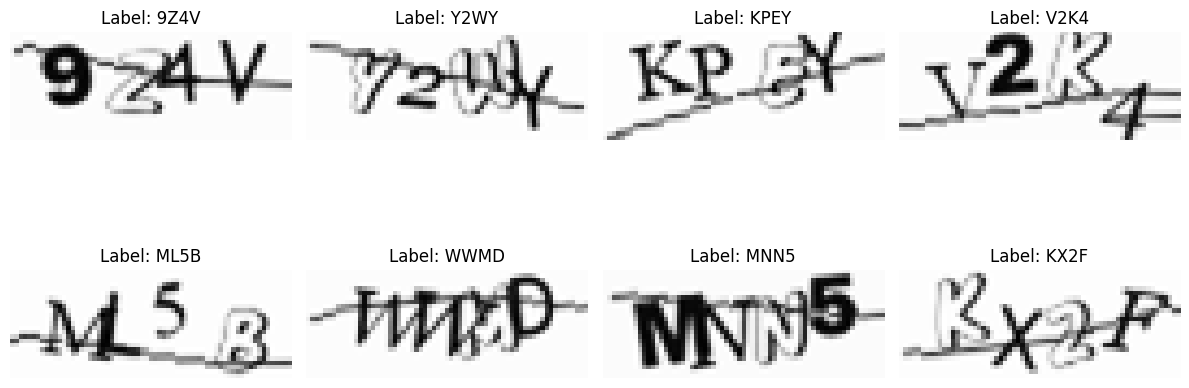

Model architecture:
ImprovedCaptchaModel(
  (cnn_layers): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.15, inplace=False)
    (8): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxPool2d(kernel_size=2, 

Epoch 1/60:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 1/60 - Train Loss: 4.0715, Val Loss: 3.7042, Validation Accuracy: 0.00% (0/400)


Epoch 2/60:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 2/60 - Train Loss: 3.6870, Val Loss: 3.6779, Validation Accuracy: 0.00% (0/400)


Epoch 3/60:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 3/60 - Train Loss: 3.6727, Val Loss: 3.6557, Validation Accuracy: 0.00% (0/400)


Epoch 4/60:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 4/60 - Train Loss: 3.5939, Val Loss: 3.6042, Validation Accuracy: 0.00% (0/400)


Epoch 5/60:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 5/60 - Train Loss: 3.5014, Val Loss: 3.6930, Validation Accuracy: 0.00% (0/400)


Epoch 6/60:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 6/60 - Train Loss: 3.3912, Val Loss: 3.4739, Validation Accuracy: 0.00% (0/400)
Early stopping triggered after 6 epochs
Best validation accuracy: 0.00%
Error in main function: [Errno 2] No such file or directory: 'best_captcha_model.pth'


Traceback (most recent call last):
  File "C:\Users\krist\AppData\Local\Temp\ipykernel_18040\2658426829.py", line 156, in main
    model, history = train_model(model, train_loader, val_loader, idx_to_char)
                     ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\krist\AppData\Local\Temp\ipykernel_18040\2658426829.py", line 130, in train_model
    model.load_state_dict(torch.load(best_model_path))
                          ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Python312\Lib\site-packages\torch\serialization.py", line 1425, in load
    with _open_file_like(f, "rb") as opened_file:
         ^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Python312\Lib\site-packages\torch\serialization.py", line 751, in _open_file_like
    return _open_file(name_or_buffer, mode)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Python312\Lib\site-packages\torch\serialization.py", line 732, in __init__
    super().__init__(open(name, mode))
                     ^^^^^^^^^^^^^

In [185]:
class EarlyStopping:
    """Early stopping to prevent overfitting and save training time
    
    Args:
        patience (int): How many epochs to wait after last improvement
        min_delta (float): Minimum change to qualify as an improvement
        mode (str): 'min' for metrics like loss where lower is better, 'max' for metrics like accuracy
    """
    def __init__(self, patience=7, min_delta=0.0, mode='min'):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.mode = mode
        
    def __call__(self, current_score):
        if self.best_score is None:
            self.best_score = current_score
            return False
        
        if self.mode == 'min':
            # For metrics where lower is better (like loss)
            delta = self.best_score - current_score
            if delta > self.min_delta:
                # Score has improved
                self.best_score = current_score
                self.counter = 0
            else:
                # Score hasn't improved
                self.counter += 1
        else:
            # For metrics where higher is better (like accuracy)
            delta = current_score - self.best_score
            if delta > self.min_delta:
                # Score has improved
                self.best_score = current_score
                self.counter = 0
            else:
                # Score hasn't improved
                self.counter += 1
                
        if self.counter >= self.patience:
            self.early_stop = True
            
        return self.early_stop

def train_model(model, train_loader, val_loader, idx_to_char):
    """Train the model and track performance metrics"""
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    model = model.to(device)

    optimizer = optim.Adam(model.parameters(), lr=CONFIG.LEARNING_RATE)

    # CTC Loss for sequence labeling
    criterion = nn.CTCLoss(blank=BLANK_TOKEN, zero_infinity=True)

    # History tracking
    history = {
        'train_loss': [],
        'val_loss': [],
        'val_accuracy': []
    }
    
    # Initialize early stopping
    early_stopping = EarlyStopping(patience=5, min_delta=0.001, mode='max')
    best_model_path = 'best_' + CONFIG.MODEL_SAVE_PATH
    best_accuracy = 0.0

    for epoch in range(CONFIG.NUM_EPOCHS):
        # Training phase
        model.train()
        train_loss = 0.0

        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{CONFIG.NUM_EPOCHS}"):
            images = batch['image'].to(device)
            labels = batch['label']
            label_lengths = batch['label_length']

            # Clear gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)

            # Prepare for CTC loss
            outputs_trans = outputs.transpose(0, 1)
            input_lengths = torch.full((outputs.size(0),), outputs.size(1), dtype=torch.long)

            # Calculate loss
            loss = criterion(outputs_trans, labels, input_lengths, label_lengths)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        # Average loss for the epoch
        train_loss /= len(train_loader)
        history['train_loss'].append(train_loss)

        # Validation phase
        accuracy, val_loss, correct, total = evaluate_with_loss(
            model, val_loader, device, idx_to_char, criterion
        )
        history['val_loss'].append(val_loss)
        history['val_accuracy'].append(accuracy)

        # Log metrics
        print(f"Epoch {epoch+1}/{CONFIG.NUM_EPOCHS} - "
                  f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
                  f"Validation Accuracy: {accuracy:.2f}% ({correct}/{total})")
        
        # Save best model
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            torch.save(model.state_dict(), best_model_path)
            print(f"New best model saved with accuracy: {accuracy:.2f}%")
            
        # Check early stopping
        if early_stopping(accuracy):
            print(f"Early stopping triggered after {epoch+1} epochs")
            print(f"Best validation accuracy: {best_accuracy:.2f}%")
            break

    # Load best model before returning
    model.load_state_dict(torch.load(best_model_path))
    print(f"Loaded best model from {best_model_path}")

    # Save final model
    torch.save(model.state_dict(), CONFIG.MODEL_SAVE_PATH)
    print(f"Final model saved to {CONFIG.MODEL_SAVE_PATH}")

    return model, history

def main():
    try:
        # 1. Load and prepare data
        train_loader, val_loader, idx_to_char, max_length = load_and_prepare_data()

        # 2. Visualize sample images
        print("Visualizing sample images from dataset:")
        visualize_dataset_samples(train_loader, idx_to_char, num_samples=8)

        # 3. Create model
        num_chars = len(idx_to_char)
        model = ImprovedCaptchaModel(num_chars)

        print("Model architecture:")
        print(f"{model}")

        # 4. Train model
        model, history = train_model(model, train_loader, val_loader, idx_to_char)

        # 5. Plot training history
        plot_history(history)

        # 6. Final evaluation
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        accuracy, val_loss, correct, total = evaluate_with_loss(
            model, val_loader, device, idx_to_char, nn.CTCLoss(blank=BLANK_TOKEN)
        )
        print(f"Final accuracy: {accuracy:.2f}% ({correct}/{total})")

        return model, history

    except Exception as e:
        print(f"Error in main function: {e}")
        import traceback
        traceback.print_exc()

if __name__ == "__main__":
    result = main()
    if result is not None:
        model, history = result